# MATH3349 / 4349 Special Topics: Computational Optimal Transport

## Assignment 1, part B: Optimal Transport with monotone rearrangment

$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This project we solve the discrete optimal transport problem 
problem (with measures that are sums of Diracs) using linear
programming.

In [5]:
import numpy as np
import scipy.optimize
import scipy.sparse
import matplotlib.pyplot as plt

# Part 2: Discrete distributions in 1 dimension
## Using monotone rearrangement

Now we're going to look at computing the monotone rearrangement for an arbitrary 1 dimensional point cloud.

We're doing this _after_ having considered the 2 dimensional problem as we can test our monotone rearrangement agains the calculation from the linear programming method.

Let's define two point clouds in $\RR$ and two vectors of weights. We'll then explicitly build the transport coupling using what we know. Again we have

$$
\alpha = \sum_{i=1}^n a_i \delta_{x_i} \quad\text{and}\quad 
\beta = \sum_{j=1}^m b_j \delta_{y_j}
$$

In [6]:
n = 8
m = 12

In [7]:
np.random.seed(2)

# Generate normally distributed, or sum of normally distributed points. 
X = np.random.randn(int(n))
Y = np.concatenate((1. * np.random.randn(int(m/2)) + 3, 1.*np.random.randn(int(m/2)) + 5))

a = np.random.random(n)
a /= a.sum()
b = np.random.random(m)
b /= b.sum()

A crucial step is to order the points spatially - which will make the calculation of inverse cumulatives easier. We label the cumulative density functions (CDFs) as ```a_cdf``` and ```b_cdf```, noting that we use the ```np.cumsum()```. We also make use of ```np.argsort```, which gives us the order to sort the ```X``` and ```Y``` vectors, which we can apply to ```a``` and ```b```.

In [8]:
X_sort = np.argsort(X)
Y_sort = np.argsort(Y)

X = X[X_sort]
Y = Y[Y_sort]

a = a[X_sort]
a_cdf = a.cumsum()

b = b[Y_sort]
b_cdf = b.cumsum()

Now let's have a look at the distributions and the corresponding cumulative density function (CDF).

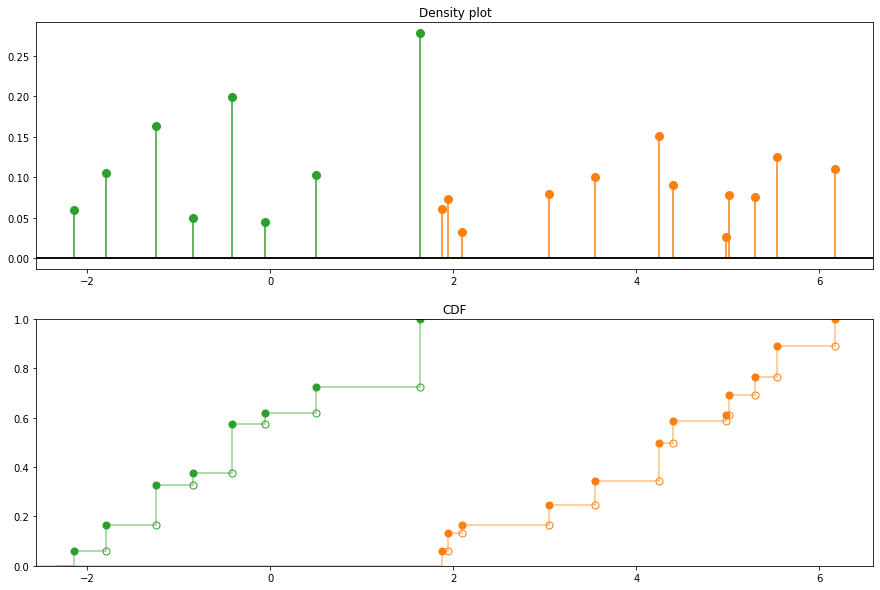

In [9]:
# Nice colours
c1 = '#2ca02c' # Forest green
c2 = '#ff7f0e' # Burnt orange

def nice_stem_plot(x, weight, col, alpha=None): 
    markerline, stemlines, baseline = plt.stem(x, weight, linefmt='-', markerfmt='o', basefmt='k-')
    plt.setp(markerline, 'markerfacecolor', col, 'color', col, 'linewidth', 2, markersize=8)
    plt.setp(stemlines, 'color', col)
    baseline.set_xdata([0,1])
    baseline.set_transform(plt.gca().get_yaxis_transform())
    #plt.axis('off')

def nice_cdf_plot(x, y, col, alpha=None):

    plt.step(x, y, where='post', c=col, alpha=0.5)
    
    plt.scatter(x, y, color=col, s=50, zorder=2)
    plt.scatter(x[1:], y[:-1], color='white', s=50, zorder=0, edgecolor=col)
    
    x_start = plt.xlim()[0]
    x_end = plt.xlim()[1]
    
    plt.step([x_start, x[0]], [0, y[0]], where='post', c=col, alpha=0.5, zorder=0)
    plt.step([x[-1], x_end], [y[-1], 1], where='pre', c=col, alpha=0.5, zorder=0)
    
plt.figure(figsize=(15, 10))

ax = plt.subplot(2, 1, 1)
ax.set_title('Density plot')
nice_stem_plot(X, a, c1)
nice_stem_plot(Y, b, c2)
xlims = plt.xlim()

ax = plt.subplot(2, 1, 2)
ax.set_title('CDF')
nice_cdf_plot(X, a_cdf, c1)
nice_cdf_plot(Y, b_cdf, c2)

plt.ylim([0., 1.])
plt.xlim(xlims)

plt.show()

## Construct the monotone rearrangement plan

Remember, it is possible, given two smooth densities $f$ and $g$ on $\RR$, to define an optimal Monge map 

$$
T(x) = G^{-1}\circ F(x).
$$

However, we saw earlier in the course that two arbitrary discrete measures usually don't posess an optimal Monge map. Rather, they have a Kantorovic style coupling.

The coupling takes a form that is somewhat similar to the map $T$ above. First define the cumulative density vector $A_i = \sum_{k=0}^i a_k$ and similar for $B_i$. Note that we are indexing from $0$, to make things easier when translating to Python. We can also define a cumulative density _function_ 

$$
A(x) = \sum_{x_i \le x} a_i = \int_{-\infty}^x \sum_{i=0}^n a_i \delta_{x_i} \, dx
$$

and a generalised inverse

$$
A^{-1}(t) = \inf \{ x : A(x)  > t \} = \min \{ n : t < \sum_{k=0}^i a_k \}.
$$

Through these generalised inverse it's possible for find a monotone rearrangement coupling that satisfies the notion that $B^{-1}(A(x_i)) = y_i$ and that the marginals hold.

First we define a _cumulative_ coupling $Q$ of $P$, 

$$
Q_{i, j} = \sum_{k, \ell = 0}^{i, j} P_{i, j}.
$$

Then as it happens, the cumulative density of the optimal coupling is simply 

$$
Q^\star_{i, j} = \min \{ A_i, B_j \}
$$

from which we can find the optimal coupling $P^\star$. For now I just leave this defined. As an exercise, you could check that this defines a monotone coupling for which the marginals hold.

### TASK 5: Find $P^\star$

Implement this method, or something similar, below.

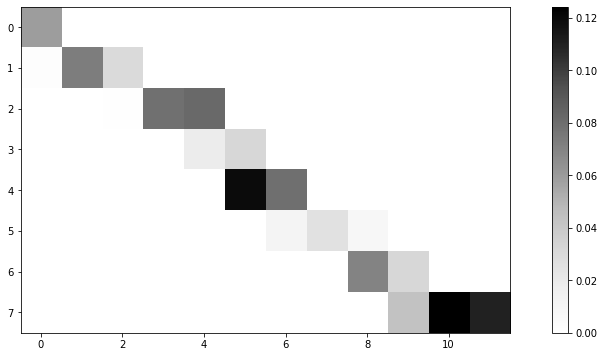

In [16]:
P = np.zeros((n, m))

# TODO: Calculate the optimal coupling P here

plt.figure(figsize = (15,6))
plt.imshow(P, cmap='Greys')
plt.colorbar()
plt.show()

## Testing the monotone rearrangent coupling

There are two ways we want to test that ```P``` is correct:
 1. That the marginals are correct, i.e. $ P \mathbb{1}_m = a $ and $P^T \mathbb{1}_n = b$
 2. That we obtain the same results with the linear programming approach
 3. (Optional) again, test for cyclic monotonicity

### TASK 6: Test the marginals of $P$

In the box below, test that the marginals of $P$ agree with $a$ and $b$.

### TASK 7: Implement the LP method for this 1d example

Now we take to implementing the LP method in this case. Much of the code will be the same as in the 2 dimensional case, except for the distance matrix, which is given for you below.

In the following cells, you have to build the ```A_eq``` and ```b_eq``` matrix as before, with the new dimensions.

In [19]:
def distance_matrix_1d(x, y, p=2):
    return np.abs(x.T[:,np.newaxis] - y.T)**p

C = distance_matrix_1d(X,Y)

In [564]:
# TODO: Compute the S and T matrix with the dimensions n and m


In [ ]:
# TODO: Build the arguments for the scipy.optimize.linprog routine and execute it

results = scipy.optimize.linprog('''TASK: Fill in the arguments here ''')

P_lp = results.x.reshape((n, m))

primal_min = results.fun
print(f'Optimal value / W_2 distance: {results.fun}')

### TASK 8: Compare the results of the monotone rearrangement and the LP method

For example, you could compare the plans graphically, or you could compute the $\ell^2$ norm of the difference of the two plans.

## What is the metric we calculate in these examples?

As has been hinted before, what we are computing is the **Wasserstein metric**, which is what we call optimal transport in the specific case that $c(x, y) = \| x - y \|^p$, or in a more general metric space, $c(x, y) = d(x, y)^p$.

Assuming that $c(x, y) = \|x - y\|^2$, we are computing the **Wasserstein-2 metric**:

$$
W_2^2 (a, b) = \min_{P \in U(a, b)} \langle C, P \rangle_F
$$

If we take our coupling/plan $P^\star$ from either the explicit monotone rearrangement or the LP solver, we have $W^2_2 (a, b) = \langle C, P^\star \rangle$, so both couplings if they are equal should give the same value, and furthermore their values should be the same as ```results.fun```, if we have ```results = scipy.optimize.linprog(...)```  above.


In [ ]:
print(f'Monotone rearrangement: W^2_2(a, b) = \t {((C * P).sum())}\n')

print(f'LP method: W^2_2(a, b) = \t\t {((C * P_lp).sum())}')